## Setup






In [0]:
# need to write a function to download all the files. maybe next time
!mkdir utils

In [2]:
import time
import os
import numpy as np
import google.colab as colab
import zipfile
import random
import json
from collections import defaultdict
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import requests
from multiprocessing import Pool

from utils.file_utils import *
from utils.image_utils import *
from utils.generator_utils import *
from utils.tqdm_utils import *
from utils.keras_utils import *


import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Mount Google Drive

In [0]:
def mount_google_drive():
	'''
	# Functionality
		Mount google drive. Since colab does not save files, we want to make it easier to directly access files in google drive.
	# Arguments
		Nothing
	# Returns
		drive_root: the working directory mounted
	'''
	mount_directory = "/content/gdrive"
	drive = colab.drive
	drive.mount(mount_directory, force_remount=True)
	drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0]
	return drive_root

In [4]:
ROOT_DIR =  mount_google_drive()
CHECKPOINT_ROOT = ROOT_DIR+ "/captioning/checkpoints/"
DATASET_DIR = ROOT_DIR + "/Dataset/"


def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(4))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/captioning/checkpoints/weights_4


## Download and Sample

In [5]:
def download_files(url):
  r = requests.get(url, stream = True)
  path = url.split("/")[-1]
  with open(path, 'wb') as f:
    for ch in r:
      f.write(ch)

tic = time.time()
url_list = [
           "http://msvocds.blob.core.windows.net/coco2014/train2014.zip",
           "http://msvocds.blob.core.windows.net/coco2014/val2014.zip",
           "http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip"
           ]
p = Pool(3)
p.map(download_files, url_list)
toc = time.time()

print("The time for downloading the full train, val dataset is", str(toc - tic), "seconds")


The time for downloading the full train, val dataset is 1088.7829155921936 seconds


### We need to speficy what fraction of the whole data is needed

In [0]:
def sample_zip(fn_in, fn_out, fraction=0.46, seed=46):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        total_num = len(fin.filelist)
        sampled = random.sample(fin.filelist, int(total_num*fraction))
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
    print("The number of sampled examples is", str(int(total_num*fraction)))


In [7]:
sample_zip("train2014.zip", DATASET_DIR + "train2014_sample.zip")
sample_zip("val2014.zip", DATASET_DIR + "val2014_sample.zip")

The number of sampled examples is 38080
The number of sampled examples is 18632


## Extract the captions

In [0]:
def get_captions_for_fns(data_fn, zip_fn, zip_json_path):
    with zipfile.ZipFile(data_fn) as fin:
      fns = fin.namelist()
    
    fns = list(map(lambda x: x.split("/")[-1], fns))
      
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))

In [9]:
train_captions = get_captions_for_fns(DATASET_DIR + "train2014_sample.zip", DATASET_DIR + "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(DATASET_DIR + "val2014_sample.zip", DATASET_DIR + "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_captions))
print(len(val_captions))

38080
18632


## Visulize the images


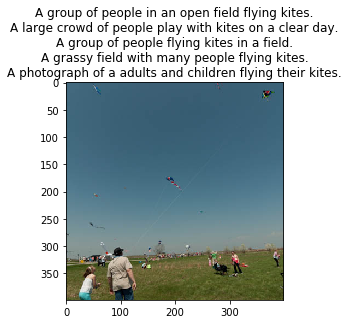

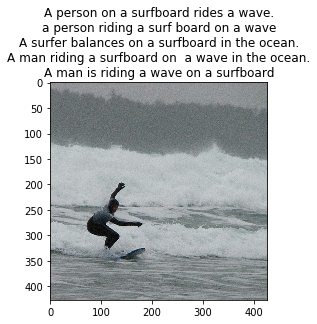

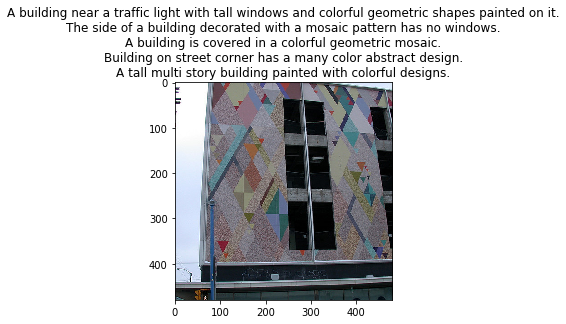

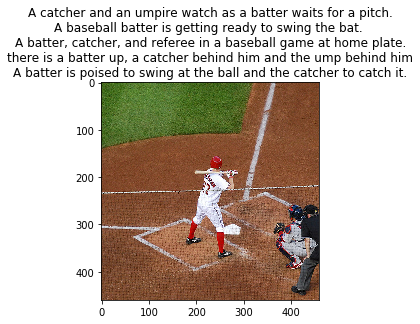

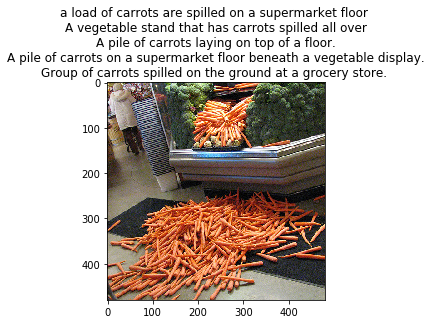

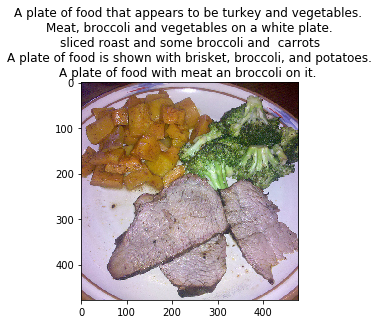

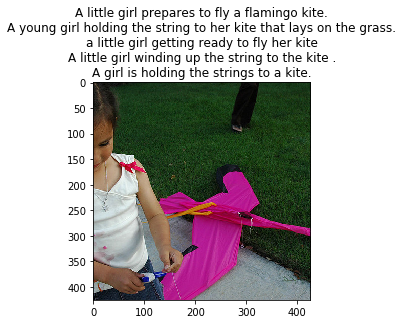

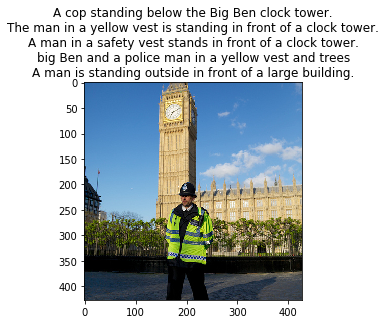

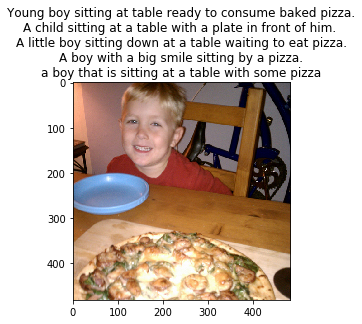

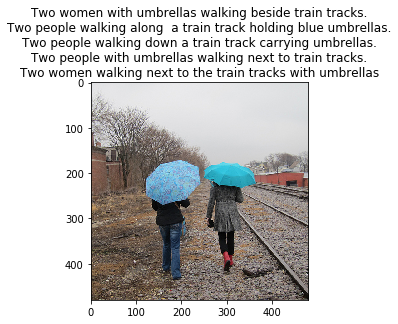

In [10]:
def show_trainig_example(train_data_fn, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    with zipfile.ZipFile(train_data_fn) as fin:
      train_img_fns = fin.namelist()
    
    train_img_fns = list(map(lambda x: x.split("/")[-1], train_img_fns))
    
    zf = zipfile.ZipFile(train_data_fn)
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = decode_image_from_raw_bytes(zf.read(example))
    plt.imshow(image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()

for i in np.random.randint(0, len(train_captions), 10):
  show_trainig_example(DATASET_DIR + "train2014_sample.zip", train_captions, example_idx=i)